In [1]:
! pip install snntorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 1.9 MB/s eta 0:00:00


In [2]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools


<ipython-input-2-bd886847109b>:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [3]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [4]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 129877017.22it/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29351997.53it/s]


Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37843869.13it/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10548465.54it/s]


Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [5]:
train_set_1, train_set_2 = torch.utils.data.random_split(mnist_train, [59800, 200])


In [6]:
train_set_1_loader = DataLoader(train_set_1, batch_size=batch_size, shuffle=True, drop_last=True)
train_set_2_loader = DataLoader(train_set_2, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
train_set_2_loader

In [8]:
# neuron and simulation parameters
#spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.9
num_steps = 30

In [22]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc1 = nn.Linear(64*4*4, 10)
        self.lif3 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk_rec = []
        mem_rec = []

        for step in range(num_steps):
          cur1 = F.max_pool2d(self.conv1(x), 2)
          spk1, mem1 = self.lif1(cur1, mem1)

          cur2 = F.max_pool2d(self.conv2(spk1), 2)
          spk2, mem2 = self.lif2(cur2, mem2)

          cur3 = self.fc1(spk2.view(batch_size, -1))
          spk3, mem3 = self.lif3(cur3, mem3)

          spk_rec.append(spk3)
          mem_rec.append(mem3)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)




In [23]:
net = Net().to(device)

In [24]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec , mem_rec = net(data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [25]:
mse_loss = nn.MSELoss()
cosine_loss = torch.nn.CosineSimilarity(dim=0)
cross_loss = nn.CrossEntropyLoss()

In [26]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 30
loss_hist = []
test_loss_hist = []
test_acc_hist =[]

test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    # Training loop
    for data, targets in iter(train_set_2_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        for step in range(num_steps):
            loss_val += cross_loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += cross_loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Test set forward pass
            test_acc = batch_accuracy(test_loader, net, num_steps)
            #print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
            test_acc_hist.append(test_acc.item())



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


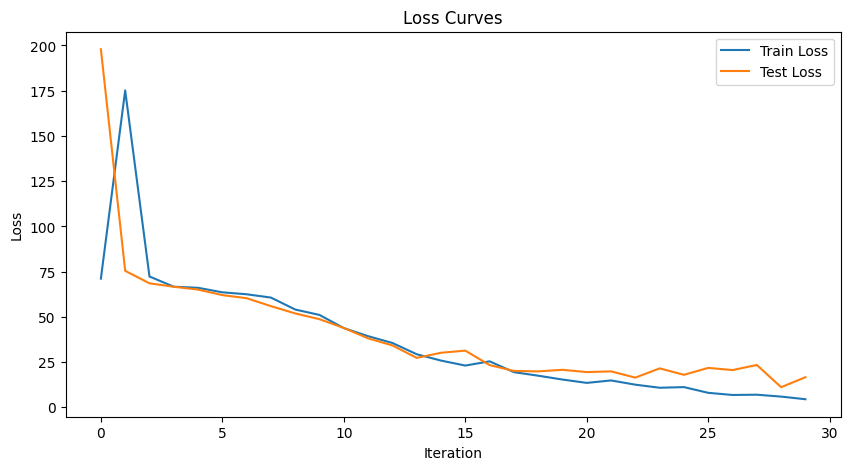

In [28]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [29]:
test_acc_hist

[0.1233974358974359,
 0.28205128205128205,
 0.30578926282051283,
 0.30298477564102566,
 0.3310296474358974,
 0.3685897435897436,
 0.3958333333333333,
 0.41626602564102566,
 0.4427083333333333,
 0.5311498397435898,
 0.6087740384615384,
 0.7050280448717948,
 0.7072315705128205,
 0.707832532051282,
 0.770332532051282,
 0.6859975961538461,
 0.746895032051282,
 0.8041866987179487,
 0.8112980769230769,
 0.7741386217948718,
 0.7653245192307693,
 0.7885616987179487,
 0.8134014423076923,
 0.8201121794871795,
 0.8338341346153846,
 0.8329326923076923,
 0.8369391025641025,
 0.8438501602564102,
 0.8490584935897436,
 0.8492588141025641]

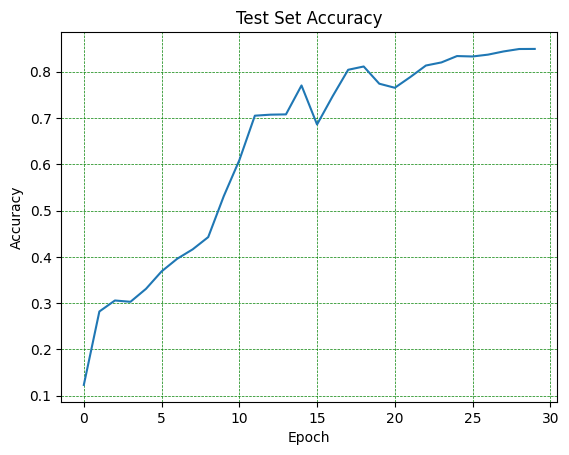

In [30]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()

In [16]:
test_spk.shape

torch.Size([30, 128, 10])

In [17]:
test_pred=test_spk.sum(dim=0).max(1)[1]


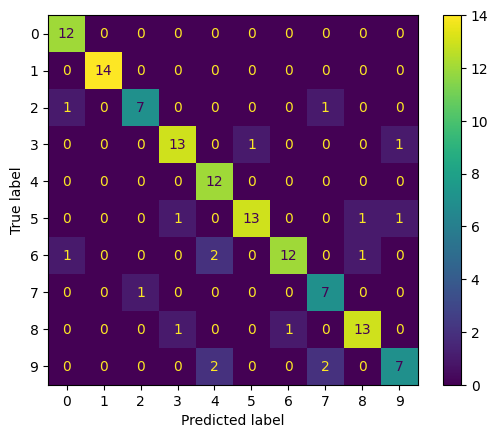

In [18]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_targets, test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()


In [19]:
acc = np.mean((test_targets == test_pred).detach().cpu().numpy())
print(acc)

0.859375
